<a href="https://colab.research.google.com/github/BillYerkes/CSEE5590_GroupProject/blob/main/Code/5590_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Code from Kaggle
//https://www.kaggle.com/varanr/hourly-energy-demand-time-series-forecast

This is JUST for reference.  THIS IS NOT OUR CODE
WE ARE USING THIS to help us learn.

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# Any results you write to the current directory are saved as output.

In [13]:
df = pd.read_csv("/content/energy_dataset.csv")

In [14]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,nan,863.0000,1051.0000,1899.0000,0.0000,7096.0000,43.0000,73.0000,49.0000,196.0000,0.0000,6378.0000,17.0000,nan,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,nan,920.0000,1009.0000,1658.0000,0.0000,7096.0000,43.0000,71.0000,50.0000,195.0000,0.0000,5890.0000,16.0000,nan,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,nan,1164.0000,973.0000,1371.0000,0.0000,7099.0000,43.0000,73.0000,50.0000,196.0000,0.0000,5461.0000,8.0000,nan,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,nan,1503.0000,949.0000,779.0000,0.0000,7098.0000,43.0000,75.0000,50.0000,191.0000,0.0000,5238.0000,2.0000,nan,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,nan,1826.0000,953.0000,720.0000,0.0000,7097.0000,43.0000,74.0000,42.0000,189.0000,0.0000,4935.0000,9.0000,nan,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [16]:
mape = np.mean(np.abs((df['total load actual'] - df['total load forecast']) / df['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.096023073723821


In [17]:
temp = df.copy() # make temporary copy of dataframe
dataset = temp['total load actual'].dropna().values # numpy.ndarray of the actual load
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) # reshape to one feature; required for the models

scaler = MinMaxScaler(feature_range=(0, 1)) # Min Max scaler
dataset = scaler.fit_transform(dataset) # fit and transform the dataset

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 # timesteps to lookback for predictions
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


In [18]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()

In [19]:
test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# invert predictions
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
Y_test = scaler.inverse_transform(test)
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Test Mean Absolute Error: 3729.264425078766
Test Root Mean Squared Error: 4391.073081234284


In [20]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

Testing MAPE: 13.333375085466773


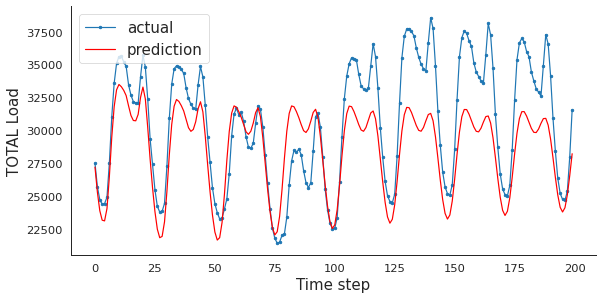

In [21]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [24]:
test_predict = np.mean(X_test, axis=2)
print('Test Mean Absolute Error:', mean_absolute_error(testY, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY, test_predict)))

Test Mean Absolute Error: 0.14497761
Test Root Mean Squared Error: 0.17464507


In [25]:
mape = np.mean(np.abs((Y_test - test_predict) / Y_test)) * 100
print("Testing MAPE: {}".format(mape))

ValueError: ignored

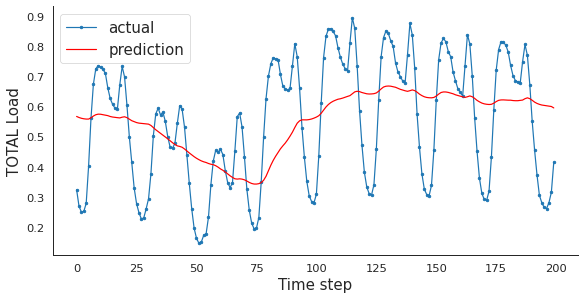

In [26]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, testY[:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [27]:
# making data again to remove inconsistencies
temp = df
dataset = temp['total load actual'].dropna().values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [28]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Epoch 1/200
400/400 [==============================] - 4s 4ms/step - loss: 0.0457 - val_loss: 0.0040
Epoch 2/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 3/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 7/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0020 - val_loss: 9.6539e-04
Epoch 8/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 9.4141e-04
Epoch 9/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0018 - val_loss: 9.2600e-04
Epoch 10/200
400/400 [==============================] - 1s 3ms/step - loss: 0.0

In [29]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 362.22221408243075
Train Root Mean Squared Error: 577.2988420486105
Test Mean Absolute Error: 346.68498701892605
Test Root Mean Squared Error: 543.7821501662205


In [30]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: 1.2965792527853524, Test MAPE: 1.2273655588190517


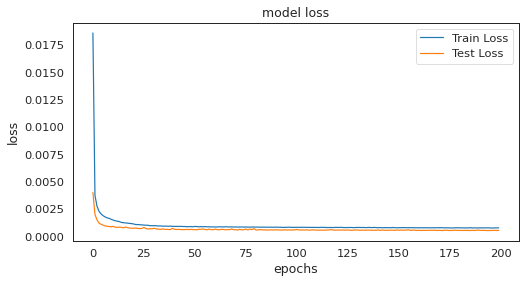

In [31]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

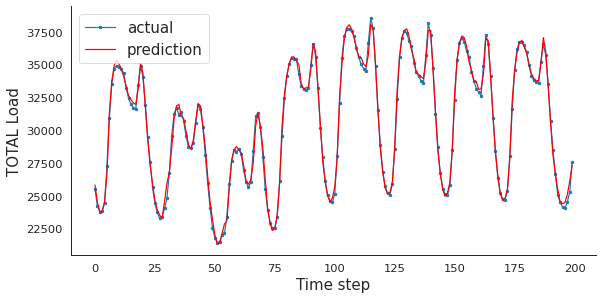

In [32]:
idx = 200
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

###END OF CODE FROM KAGGLE

### OUR CODE STARTS HERE

## Import & Install PySpark

In [1]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 72kB/s 
     |████████████████████████████████| 204kB 46.5MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=eee41eb9465b45ad7dc01b8880efe8acfd749c171c40590e4c62db278ee2ed08
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [2]:
import pyspark
from pyspark.sql import SparkSession
sc = pyspark.SparkContext('local[*]')

### pyspark.sql.SparkSession Main entry point for DataFrame and SQL functionality.
#### The entry point to programming Spark with the Dataset and DataFrame API.

A SparkSession can be used create DataFrame, register DataFrame as tables, execute SQL over tables, cache tables, and read parquet files. To create a SparkSession, use the following builder pattern:
[Source](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SparkSession)

In [3]:
spark = SparkSession.builder.master("local").appName("cs5590").config("spark.some.config.option", "some-value").getOrCreate()

### Data frames of Energy and Weather data

In [56]:
import pandas as pd   

url = 'https://raw.githubusercontent.com/BillYerkes/CSEE5590_GroupProject/main/Data/energy_dataset.csv'
pandaDF_Energy = pd.read_csv(url)

In [57]:
EnergyDF = spark.createDataFrame(pandaDF_Energy)
EnergyDF.printSchema()
EnergyDF.show()
EnergyDF.count()


root
 |-- time: string (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil coal-derived gas: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation fossil oil shale: double (nullable = true)
 |-- generation fossil peat: double (nullable = true)
 |-- generation geothermal: double (nullable = true)
 |-- generation hydro pumped storage aggregated: double (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation marine: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- gener

35064

This is a test comment

In [58]:
url = 'https://raw.githubusercontent.com/BillYerkes/CSEE5590_GroupProject/main/Data/weather_features.csv'
pandaDF_Weather = pd.read_csv(url)

In [59]:
WeatherDF = spark.createDataFrame(pandaDF_Weather)
WeatherDF.printSchema()
WeatherDF.show()
WeatherDF.count()


root
 |-- dt_iso: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- temp_min: double (nullable = true)
 |-- temp_max: double (nullable = true)
 |-- pressure: long (nullable = true)
 |-- humidity: long (nullable = true)
 |-- wind_speed: long (nullable = true)
 |-- wind_deg: long (nullable = true)
 |-- rain_1h: double (nullable = true)
 |-- rain_3h: double (nullable = true)
 |-- snow_3h: double (nullable = true)
 |-- clouds_all: long (nullable = true)
 |-- weather_id: long (nullable = true)
 |-- weather_main: string (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- weather_icon: string (nullable = true)

+--------------------+---------+------------------+------------------+------------------+--------+--------+----------+--------+-------+-------+-------+----------+----------+------------+-------------------+------------+
|              dt_iso|city_name|              temp|          temp_min|          temp_max|

178396

#Query to get count for each City

In [60]:
city = WeatherDF.select('city_name')

city.printSchema()
city.count()

city.groupBy("city_name").count().show()

root
 |-- city_name: string (nullable = true)

+----------+-----+
| city_name|count|
+----------+-----+
|    Madrid|36267|
|   Seville|35557|
| Barcelona|35476|
|    Bilbao|35951|
|  Valencia|35145|
+----------+-----+



Convert String to Time stamp and pull out hour and minute offset

In [61]:
import pyspark.sql.functions as f
from pyspark.sql.functions import *

EnergyDF = EnergyDF.withColumn('dtTimeStamp', to_timestamp(f.substring('time', 1,19), 'yyyy-MM-dd HH:mm:ss')) \
                   .withColumn('dtHourOffset', f.substring('time', 21,2)) \
                   .withColumn('dtMinuteOffset', f.substring('time', 24,2))

WeatherDF = WeatherDF.withColumn('dtTimeStamp', to_timestamp(f.substring('dt_iso', 1,19), 'yyyy-MM-dd HH:mm:ss')) \
                     .withColumn('dtHourOffset', f.substring('dt_iso', 21,2)) \
                     .withColumn('dtMinuteOffset', f.substring('dt_iso', 24,2))

EnergyDF.printSchema()                   

root
 |-- time: string (nullable = true)
 |-- generation biomass: double (nullable = true)
 |-- generation fossil brown coal/lignite: double (nullable = true)
 |-- generation fossil coal-derived gas: double (nullable = true)
 |-- generation fossil gas: double (nullable = true)
 |-- generation fossil hard coal: double (nullable = true)
 |-- generation fossil oil: double (nullable = true)
 |-- generation fossil oil shale: double (nullable = true)
 |-- generation fossil peat: double (nullable = true)
 |-- generation geothermal: double (nullable = true)
 |-- generation hydro pumped storage aggregated: double (nullable = true)
 |-- generation hydro pumped storage consumption: double (nullable = true)
 |-- generation hydro run-of-river and poundage: double (nullable = true)
 |-- generation hydro water reservoir: double (nullable = true)
 |-- generation marine: double (nullable = true)
 |-- generation nuclear: double (nullable = true)
 |-- generation other: double (nullable = true)
 |-- gener

Function so we can add offset back to time stamp

We are saving it as a string, we will later convert it back to a timestamp

In [62]:
from datetime import datetime, timedelta
format = "%Y-%m-%d %H:%M:%S"

def addTimeOffset(v_date, v_hour, v_minute):
  new_datetime = timedelta(minutes = int(v_minute), hours = int(v_hour))
  return_dt = v_date + new_datetime
  date_string = return_dt.strftime(format)
  return date_string
udfaddTimeOffset = f.udf(addTimeOffset, StringType())



In [65]:
EnergyDF = EnergyDF.na.drop(subset=['total load actual'])


Add new timestamp to DF with offset added to them

In [66]:
EnergyDF = EnergyDF.withColumn("interval", udfaddTimeOffset("dtTimeStamp","dtHourOffset","dtMinuteOffset"))
EnergyDF = EnergyDF.withColumn('dtTimeStampUpdated', to_timestamp("interval", 'yyyy-MM-dd HH:mm:ss'))

WeatherDF = WeatherDF.withColumn("interval", udfaddTimeOffset("dtTimeStamp","dtHourOffset","dtMinuteOffset"))
WeatherDF = WeatherDF.withColumn('dtTimeStampUpdated', to_timestamp("interval", 'yyyy-MM-dd HH:mm:ss'))


EnergyDF.select('dtTimeStamp','dtTimeStampUpdated').show()
WeatherDF.select('dtTimeStamp','dtTimeStampUpdated').show()

+-------------------+-------------------+
|        dtTimeStamp| dtTimeStampUpdated|
+-------------------+-------------------+
|2015-01-01 00:00:00|2015-01-01 01:00:00|
|2015-01-01 01:00:00|2015-01-01 02:00:00|
|2015-01-01 02:00:00|2015-01-01 03:00:00|
|2015-01-01 03:00:00|2015-01-01 04:00:00|
|2015-01-01 04:00:00|2015-01-01 05:00:00|
|2015-01-01 05:00:00|2015-01-01 06:00:00|
|2015-01-01 06:00:00|2015-01-01 07:00:00|
|2015-01-01 07:00:00|2015-01-01 08:00:00|
|2015-01-01 08:00:00|2015-01-01 09:00:00|
|2015-01-01 09:00:00|2015-01-01 10:00:00|
|2015-01-01 10:00:00|2015-01-01 11:00:00|
|2015-01-01 11:00:00|2015-01-01 12:00:00|
|2015-01-01 12:00:00|2015-01-01 13:00:00|
|2015-01-01 13:00:00|2015-01-01 14:00:00|
|2015-01-01 14:00:00|2015-01-01 15:00:00|
|2015-01-01 15:00:00|2015-01-01 16:00:00|
|2015-01-01 16:00:00|2015-01-01 17:00:00|
|2015-01-01 17:00:00|2015-01-01 18:00:00|
|2015-01-01 18:00:00|2015-01-01 19:00:00|
|2015-01-01 19:00:00|2015-01-01 20:00:00|
+-------------------+-------------

Grouping Data by time stamp,

Averging Temp

In [68]:


WeatherTempDF = WeatherDF.groupBy('dtTimeStampUpdated').agg(f.avg("temp").alias("Temp_avg"))

WeatherEnergyDF = WeatherTempDF.join(EnergyDF, on=['dtTimeStampUpdated'], how='inner')

PandasWeatherEnergyDF = WeatherEnergyDF.toPandas()
X = PandasWeatherEnergyDF[['Temp_avg']]
y = PandasWeatherEnergyDF[['total load actual']]



In [70]:
# importing libraries
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:

WeatherEnergyDF.agg({'total load actual': 'max'}).show()


+----------------------+
|max(total load actual)|
+----------------------+
|               41015.0|
+----------------------+



In [71]:
#train using the data
body_reg = linear_model.LinearRegression()
body_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [72]:
# parameters
m =body_reg.coef_
c =body_reg.intercept_

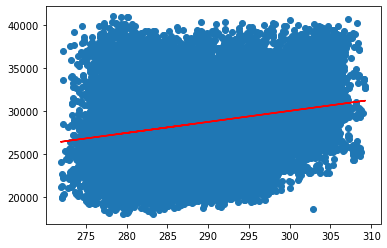

In [75]:
plt.scatter(X,y)
plt.plot(X,body_reg.predict(X),color='Red')

### Inner Join between the weather and energy dataframes

In [26]:

WeatherEnergyDF = WeatherDF.join(EnergyDF, on=['dtTimeStampUpdated'], how='inner')


Perform a Linear Regression

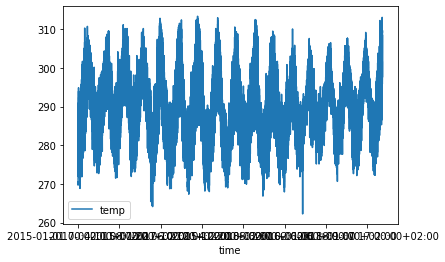

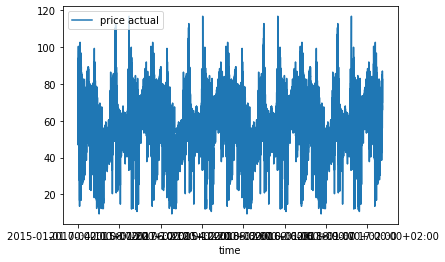

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df_plot = df_inner.toPandas()

df_plot.plot(x="time", y=["temp"])
plt.show()

df_plot.plot(x="time", y=["price actual"])
plt.show()